# Categorical Predictors

In this notebook, we will walk through the effects categorical columns have on algorithms like GBM and Random Forest, particularly categorical columns with high cardinality.  We will also walk through two methods for dealing with high cardinality columns: 

* comparing model performance after removing high cardinality columns
* parameter tuning (specifically tuning `nbins_cats` and `categorical_encoding`)

A common method for dealing with high cardinality categorical predictors is to perform categorical encoding such as: Target Encoding, Frequency Encoding, etc.  These methods are not evaluated in this notebook.

The effects of categorical columns are similar for both the GBM and Random Forest model.  For this notebook, we will be using the GBM algorithm.

## Train Model with Random Categorical Predictor

We will start out by training a GBM model to predict the column `bad_loan` in our cleaned lending club data:  https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv.  We will add a random categorical predictor to the data to see how it impacts our model. The random categorical column will have 500 unique values. 

In [1]:
# Start H2O Cluster
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.7.0_80"; Java(TM) SE Runtime Environment (build 1.7.0_80-b15); Java HotSpot(TM) 64-Bit Server VM (build 24.80-b11, mixed mode)
  Starting server from /Users/megankurka/anaconda3/envs/py27/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpKffvDJ
  JVM stdout: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpKffvDJ/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpKffvDJ/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_megankurka_35wba8
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [2]:
# Import the data into H2O
df = h2o.import_file("https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv",
                     col_types = {'bad_loan':"enum"}
                    )

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
# Add Random Categorical Column with 500 Unique Values
random_cat = h2o.create_frame(rows = df.nrow, cols = 1, 
                              binary_fraction = 0, time_fraction = 0, integer_fraction = 0, string_fraction = 0,
                              categorical_fraction = 1, factors = 500, # Random Categorical Column with 500 Values
                              has_response = False, seed = 1234
                             )

Create Frame progress: |██████████████████████████████████████████████████| 100%


In [4]:
ext_df = df.cbind(random_cat)

In [5]:
# Split Frame into training and testing
train, test = ext_df.split_frame(seed = 1234, destination_frames=["train.hex", "test.hex"])

In [6]:
# Train GBM
from h2o.estimators import H2OGradientBoostingEstimator

response = "bad_loan"
predictors = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 
              'longest_credit_length', 'verification_status', 'term', 'purpose', 'home_ownership', 'C1']

gbm_v1 = H2OGradientBoostingEstimator(model_id = "gbm_v1.hex",
                                      score_tree_interval = 10, ntrees = 500,
                                      ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                      ## for 5 consecutive scoring events
                                      stopping_rounds = 5, stopping_metric = "AUC", stopping_tolerance = 0.001
                                     )
gbm_v1.train(x = predictors, y = response, 
             training_frame = train, validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


The training and validation logloss diverge very quickly in the scoring history. This is also visible by the large difference in training and validation AUC.

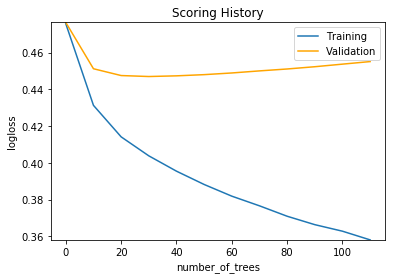

In [7]:
gbm_v1.plot()

In [8]:
# Get AUC
print("Training AUC: " + str(round(gbm_v1.auc(train = True), 3)))
print("Validation AUC: " + str(round(gbm_v1.auc(valid = True), 3)))

Training AUC: 0.85
Validation AUC: 0.671


Our most important variable is the random categorical variable!!  This tells us that our model is memorizing the training data through this high cardinality categorical column.

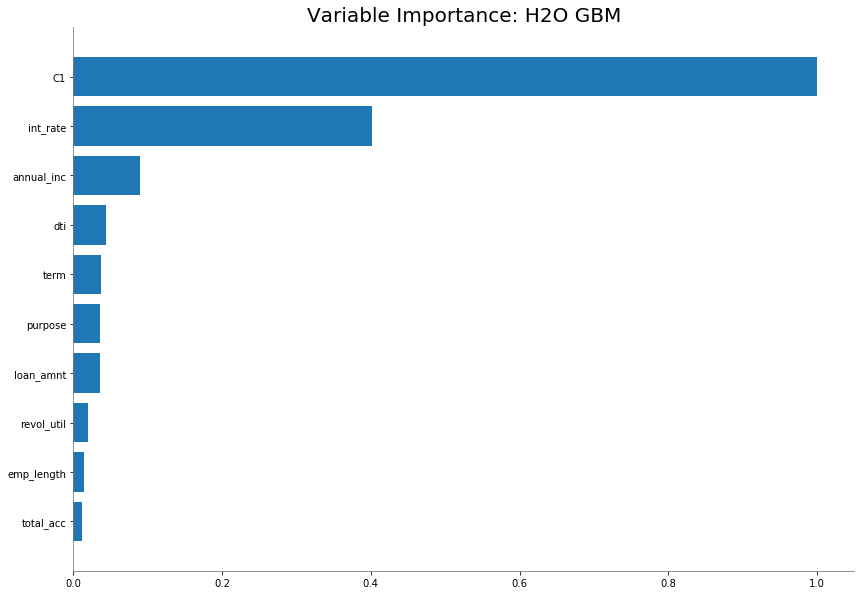

In [9]:
# Plot Variable Importance

gbm_v1.varimp_plot()

### Tree Visualization

Let's take a look at the trees in the GBM model to understand how they are using our `C1` variable.

The code below will create an image of a chosen tree in the GBM model from the MOJO.

In [10]:
import subprocess
from IPython.display import Image

def generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_path, tree_id = 0):
    result = subprocess.call(["java",  "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", str(tree_id), "-i",  mojo_full_path , "-o", gv_file_path ], shell=False)
    result = subprocess.call(["ls",gv_file_path], shell = False)
    if result is 0:
        print("Success: Graphviz file " + gv_file_path + " is generated.")
    else:    
        print("Error: Graphviz file " + gv_file_path + " could not be generated.")
        
def displayTreeImage(gv_file_path, image_file_path):
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    if result is 0:
        print("Success: Image File " + image_file_path + " is generated.")
        print("Now you can execute the follow line as-it-is to see the tree graph:") 
        print("Image(filename='" + image_file_path + "\')")
    else:
        print("Error: Image file " + image_file_path + " could not be generated.")

In [11]:
h2o_jar_path= '../../../../Downloads/h2o-3.16.0.4/h2o.jar'
mojo_file_name = "./gbm_v1.zip"
gv_file_path = "./gbm_v1.gv"
image_file_path = "./gbm_v1.png"

Success: Graphviz file ./gbm_v1.gv is generated.
Success: Image File ./gbm_v1.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='./gbm_v1.png')


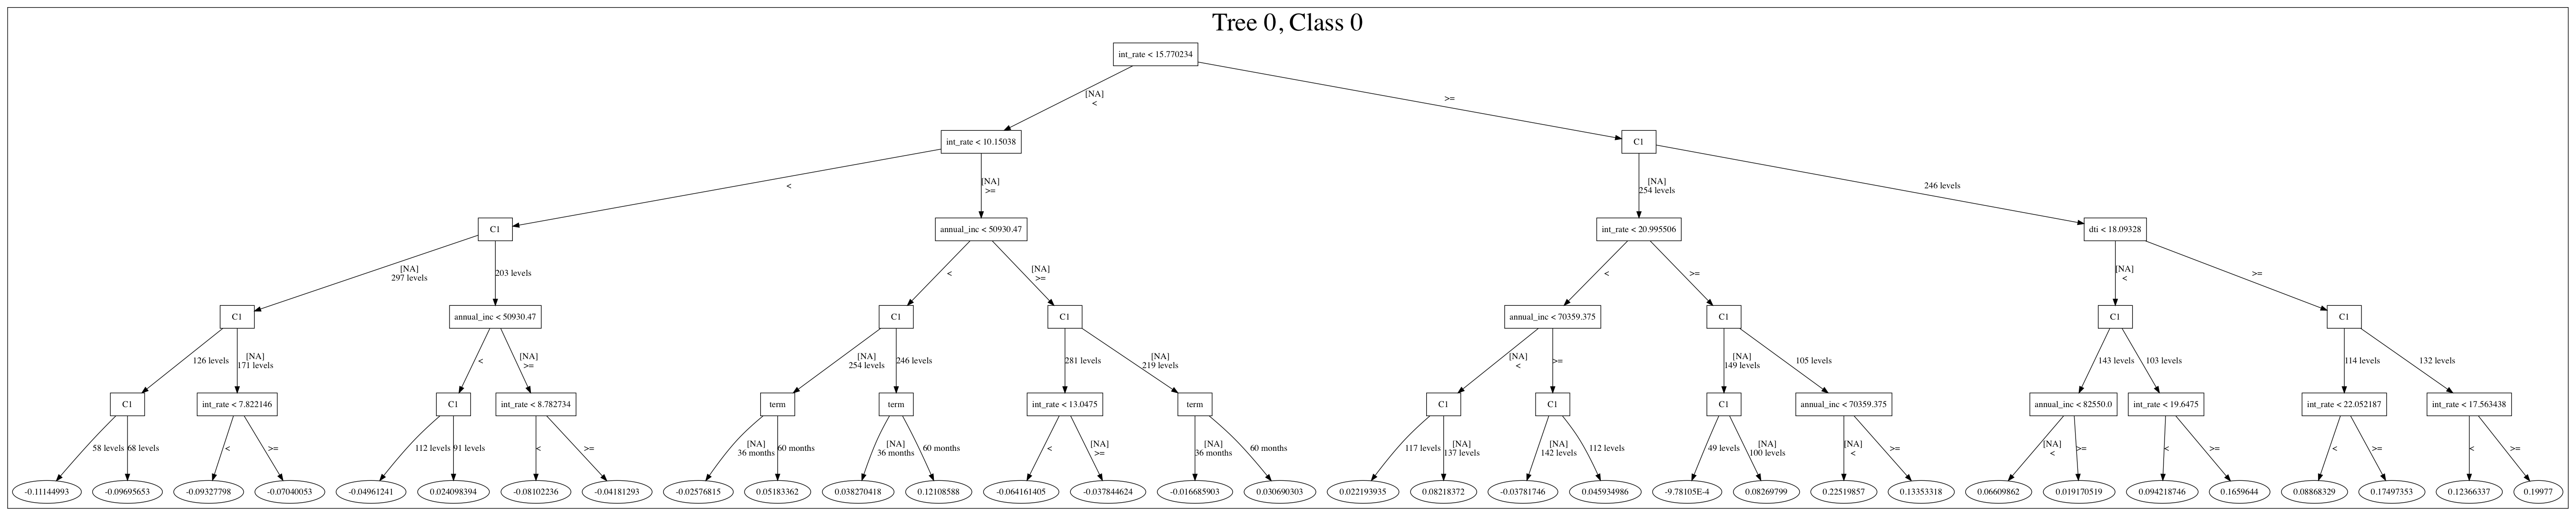

In [12]:
gbm_v1.download_mojo(mojo_file_name);
generateTree(h2o_jar_path, mojo_file_name, gv_file_path, image_file_path, 0)
displayTreeImage(gv_file_path, image_file_path)
Image(filename=image_file_path)

The tree shows us that the first split is on `int_rate` but throughout the tree it continually splits on `C1`.  It splits on `C1` a total of 13 times in the first tree. The tree only splits on the predictor `int_rate` (which is known to be correlated with `bad_loan`) 9 times.

## Train Model without Random Categorical Predictor

We will train the same GBM model, this time without the random categorical column.

In [13]:
# Train GBM without Random Categorical
new_predictors = list(set(predictors) - set(["C1"]))

gbm_v2 = H2OGradientBoostingEstimator(model_id = "gbm_v2.hex",
                                      score_tree_interval = 10, ntrees = 500,
                                      ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                      ## for 5 consecutive scoring events
                                      stopping_rounds = 5, stopping_metric = "AUC", stopping_tolerance = 0.001
                                     )
gbm_v2.train(x = new_predictors, y = response, 
             training_frame = train, validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [14]:
# Get AUC
print("V1 Validation AUC: " + str(round(gbm_v1.auc(valid = True), 3)))
print("V2 Validation AUC: " + str(round(gbm_v2.auc(valid = True), 3)))

V1 Validation AUC: 0.671
V2 Validation AUC: 0.708


Our AUC has jumped by 0.4 just by removing this column.

Let's visualize the first tree of our new GBM model.

In [15]:
mojo_file_name = "./gbm_v2.zip"
gv_file_path = "./gbm_v2.gv"
image_file_path = "./gbm_v2.png"

Success: Graphviz file ./gbm_v2.gv is generated.
Success: Image File ./gbm_v2.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='./gbm_v2.png')


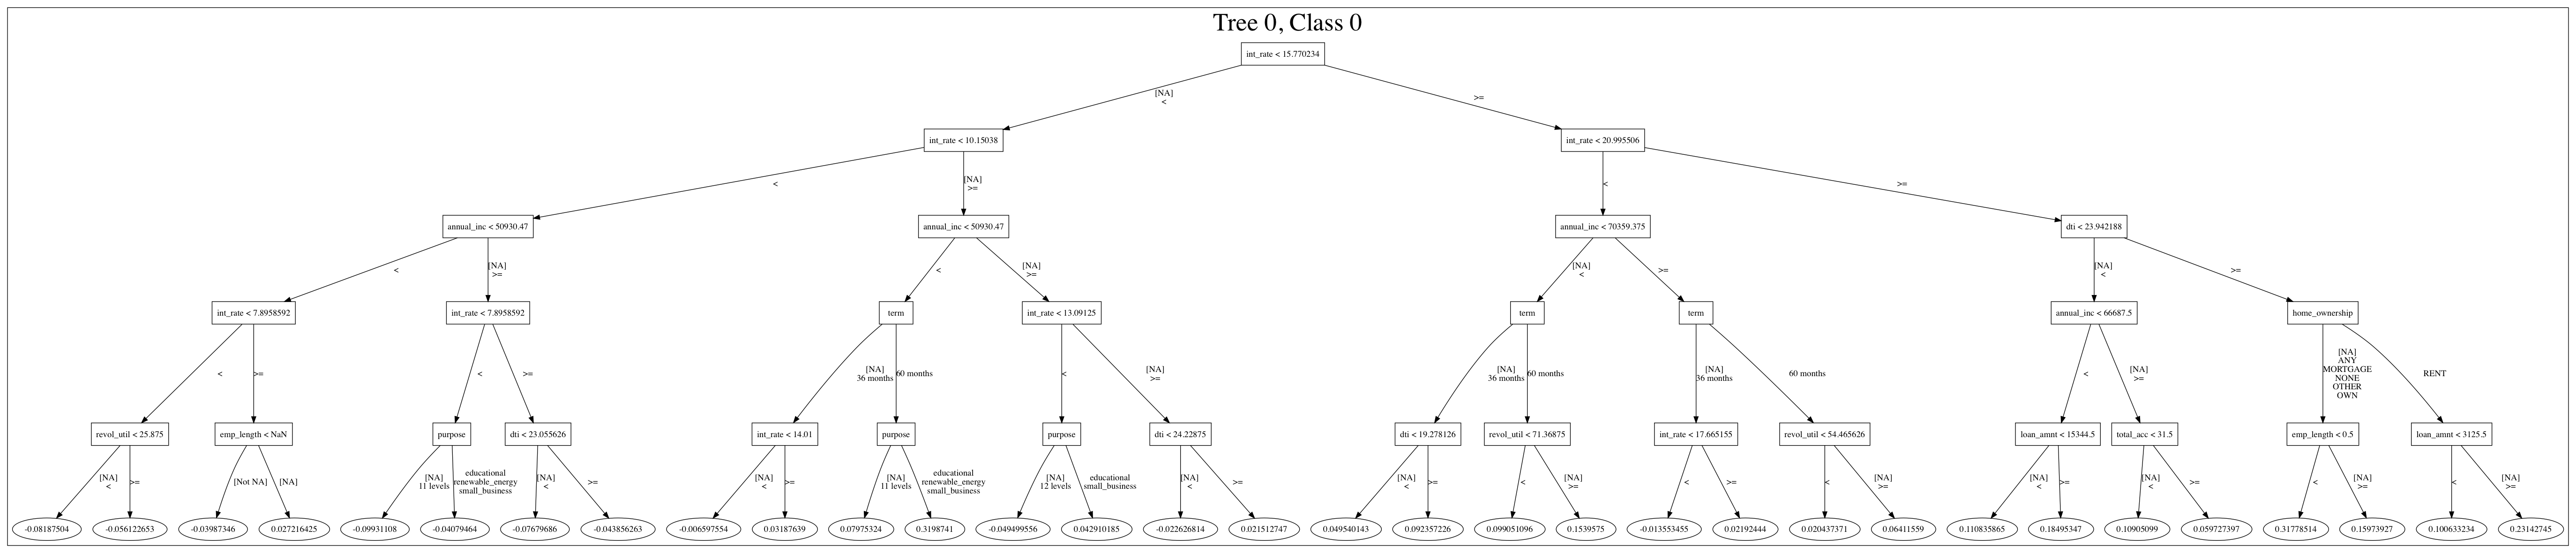

In [16]:
gbm_v2.download_mojo(mojo_file_name);
generateTree(h2o_jar_path, mojo_file_name, gv_file_path, image_file_path, 0)
displayTreeImage(gv_file_path, image_file_path)
Image(filename=image_file_path)

Now the predictors: `int_rate` and `annual_inc` dominate the tree.

## Analyzing the Effect of Cardinality on Variable Importance

We can hypothesize that our random categorical column had high variable importance because of the high number of levels (500).  The GBM model could have used this model to start memorizing the training data.  

Below we will analyze the relative variable importance of random categorical columns with different cardinality.

In [17]:
def VarimpByCardinality(data, cardinality, response):
    
    random_cat = h2o.create_frame(rows = data.nrow, cols = 1, 
                                  binary_fraction = 0, time_fraction = 0, integer_fraction = 0, string_fraction = 0,
                                  categorical_fraction = 1, factors = cardinality, 
                                  has_response = False, seed = 1234
                             )
    
    data = data.cbind(random_cat)
    
    train, test = data.split_frame(seed = 1234)
    
    predictors = list(set(train.col_names) - set([response]))
    
    gbm = H2OGradientBoostingEstimator(model_id = "gbm.hex",
                                       score_tree_interval = 10, ntrees = 500,
                                       ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                       ## for 5 consecutive scoring events
                                       stopping_rounds = 5, stopping_metric = "AUC", stopping_tolerance = 0.001
                                      )
    
    gbm.train(x = predictors, y = response, training_frame = train, validation_frame = test)
    
    varimp = gbm.varimp(use_pandas = True)
    random_varimp = varimp[varimp["variable"] == "C1"]["relative_importance"].min()
    
    return random_varimp

In [18]:
cardinalities = [2, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
varimp = []
h2o.no_progress()

for i in cardinalities:
    varimp = varimp + [VarimpByCardinality(df, i, "bad_loan")]

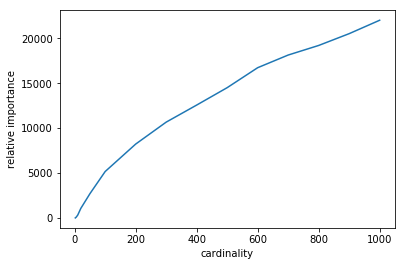

In [19]:
import matplotlib.pyplot as plt

plt.plot(cardinalities, varimp)
plt.xlabel('cardinality') 
plt.ylabel('relative importance')
plt.show()

The graph above shows us that the greater the cardinality of the random categorical column, the more important it becomes. This shows that the more unique values in the categorical column, the more times the GBM splits on it.

## Grid Search 

We can use grid search to find the optimal parameters of our GBM model.  Two important parameters to tune when dealing with categorical columns are: 

* `categorical_encoding`: encoding scheme for categorical features
    * http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/categorical_encoding.html
* `nbins_cats`: build a histogram of this many bins, then split at the best point
    * http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/nbins_cats.html
    
We will run a random grid search trying to find the optimal `nbins_cats` and `categorical_encoding`.

In [ ]:
from h2o.grid import H2OGridSearch

hyper_params = hyper_params = {
    ## search for the best categorical encoding
    'categorical_encoding':["Enum", "OneHotExplicit", "Binary", "Eigen", "LabelEncoder", 
                            "SortByResponse", "EnumLimited"],
    
    ## search a large space of the number of bins for split-finding for categorical columns
    'nbins_cats':[16, 32, 64, 128]
}

search_criteria = {
    ## Random grid search
    'strategy':"RandomDiscrete",      
    
    ## limit the runtime to 60 minutes
    'max_runtime_secs':3600,         
    
    ## build no more than 15 models for example purposes
    'max_models':15,                  
  
    ## random number generator seed to make sampling of parameter combinations reproducible
    'seed':1234,                        
  
    # early stopping once the leaderboard of the top 5 models is converged to 0.1% relative difference
    'stopping_rounds':5, 'stopping_metric':"AUC", 'stopping_tolerance':1e-3
}

In [ ]:
gbm_model = H2OGradientBoostingEstimator(
    ntrees = 500,              
    
    ## early stopping once the validation AUC doesn't improve by at least 0.1% for 5 consecutive scoring events
    stopping_rounds = 5, stopping_tolerance = 0.001, stopping_metric = "AUC", 
  
    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10,                                                
  
    ## base random number generator seed for each model (automatically gets incremented internally for each model)
    seed = 1234     
)

gbm_grid = H2OGridSearch(grid_id="grid.hex", hyper_params=hyper_params, 
                         model=gbm_model, search_criteria=search_criteria)

gbm_grid.train(x = predictors, y = response, training_frame=train, validation_frame=test)

In [ ]:
sorted_grid = gbm_grid.get_grid(sort_by="auc", decreasing=True)
sorted_grid

The grid search summary shows us that the two models with the highest validation AUC were those with small `nbins_cats`.  The two best models have `nbins_cats` = 16 and where the `categorical_encoding` is Enum or EnumLimited. EnumLimited automatically reduces categorical levels to the most prevalent ones during training and only keep the `T` most frequent levels. 

The best grid search model has similar AUC to our GBM model trained without the random categorical.  When we examine the variable importance, we can see that `C1` is no longer in the top features.

In [ ]:
best_model = sorted_grid.models[0]

print("V1 Validation AUC: " + str(round(gbm_v1.auc(valid = True), 3)))
print("V2 Validation AUC: " + str(round(gbm_v2.auc(valid = True), 3)))
print("Best Validation AUC Grid Search: " + str(round(best_model.auc(valid = True), 3)))

In [ ]:
best_model.varimp_plot()

In [ ]:
h2o.cluster().shutdown()